
# Тема 18. Распределение деталей по классам

Взята из "Список примерных тем" https://drive.google.com/file/d/1JSvNRD_QzE0sEhfs6eL7CWGIbccK9JZs/view?usp=sharing

Необходимо научить нейронную сеть определять предметы из предоставленного датасета

База https://www.kaggle.com/nolewit/simple-images-dataset

# Обзор набора данных, простая загрузка

# Libraryes

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv2D,  MaxPooling2D, GlobalMaxPooling2D # Базовые слови
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотекиДаimage для работы с изображениями
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LambdaCallback, LearningRateScheduler
from tensorflow.keras.utils import plot_model
import numpy as np # Импортируем библиотеку numpy
import random
import shutil
import time
import os # Импортируем библиотеку os для раоты с файловой системой
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image, ImageEnhance # импортируем модель Image для работы с изображениями

In [ ]:
if os.path.exists('/content/images'): shutil.rmtree('/content/images')
! unzip -q /content/drive/MyDrive/dip/train1.zip -d /content/images/
! unzip -q /content/drive/MyDrive/dip/train2.zip -d /content/images/
!rm /content/images/bea/15608.png    # битый

In [ ]:
class DataLoader():
  def __init__(self, path):
    self.path = path
    self.clName = sorted(os.listdir(path))

  def loadImgFile(self, fPath):           # Загрузка изображения из файла
    return np.array(image.load_img(fPath)).astype('float32')/255    # изображение в виде массива  0 - 1.

  def loadImages(self, ncl):              # Загрузка класса
    for n, imfile in enumerate(os.listdir(self.path + self.clName[ncl])):  #  для каждого изображения  

      img = self.loadImgFile(os.path.join(self.path + self.clName[ncl], imfile))

      xTrain.append(img)           # добавим в список обуч.  
      yTrain.append(ncl)


  def loadDataSet(self):      # Загрузка изображений
    for nc in range(len(self.clName)):
      self.loadImages(nc)     # загрузим избражениЯ
      print(self.clName[nc], end = '   ')

    return self.clName

dl = DataLoader('/content/images/')
xTrain,xTest, yTrain,yTest = [],[], [],[]
print('Поехали:') 
className = dl.loadDataSet()
del dl

nClasses = len(className)
xTrain = np.array(xTrain)
#xTest = np.array(xTest)
yTrain = utils.to_categorical(yTrain, nClasses)
#yTest = utils.to_categorical(yTest, nClasses)

print(xTrain.shape, yTrain.shape)  

Поехали:
bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (74791, 71, 71, 3) (74791, 10)


In [ ]:
n = 10 # Количество выводимых случайных картинок
fig, axs = plt.subplots(n, n, figsize=(24, 24)) # Создаем полотно из n*n графиков
for i in range(n): # Проходим по классам
  label_indexes = np.where(np.argmax(yTrain, axis=1)==i%10)[0] # Получаем список из индексов положений класса 
  for j in range(n):
    indx = random.choice(label_indexes) # Случайным образом выбираем из списка индекс
    axs[i,j].imshow(xTrain[indx]) # Отображаем фото
plt.show() # Показываем изображения  

[4939, 8496, 2737, 7718, 9455, 2093, 2817, 8209, 8225, 20102]


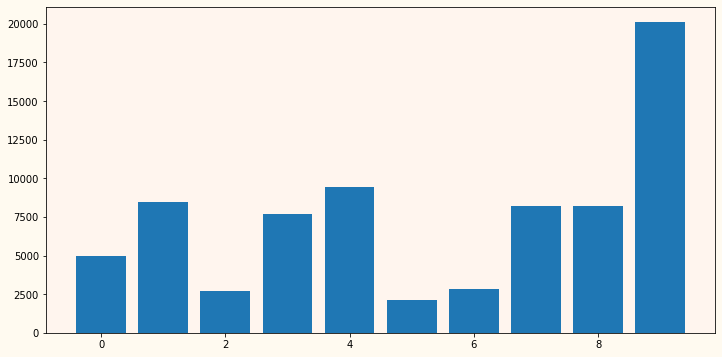

In [ ]:
nsample = []
for cl in range(nClasses) :
  mask = np.argmax(yTrain, axis=1) == cl    # Маска на класс
  nsample.append(xTrain[mask].shape[0])
print(nsample)
  
fig, ax = plt.subplots()
x = [i for i in range(nClasses)]
ax.bar(x, nsample)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Разбиваем датасет на тренировочный и тестовый при помощи функции train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(xTrain, yTrain, test_size=0.2)

# Первый вариант сети

 
*   Сеть построена на основе сверточных слоёв Керас.
*  Использовано две параллельные ветви с разным ядром свертки.
*  Имеются пробросы с предпосдеднего блока свертки.


In [ ]:
in0 = Input((71, 71, 3))        # Входной слой для 2-x веток

# для 1-й ветви
x0 = Conv2D(8, (3,3), padding="same", activation="elu")(in0)
x0 = Conv2D(8, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0 = Conv2D(16, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(16, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0_m2 = Flatten()(x0)
x0 = Conv2D(32, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(32, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = MaxPooling2D(2)(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0_m4 = Flatten()(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0 = Flatten()(x0)

# для 2-й ветви  strides=4
x1 = Conv2D(16, (5,5), padding="same", activation="elu")(in0)
x1 = Conv2D(16, (5,5), padding="same", strides=4, activation="elu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1_m1 = Flatten()(x1)
x1 = Conv2D(64, (5,5), padding="same", activation="elu")(x1)
x1 = Conv2D(64, (5,5), padding="same", strides=4, activation="elu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)

# Объедияем блоки
x = concatenate([x0, x1,  x0_m4, x1_m1])

# Полносвязные слои на выходе
x = Dense(1000, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(nClasses, activation='softmax')(x)

model = Model(in0, x)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

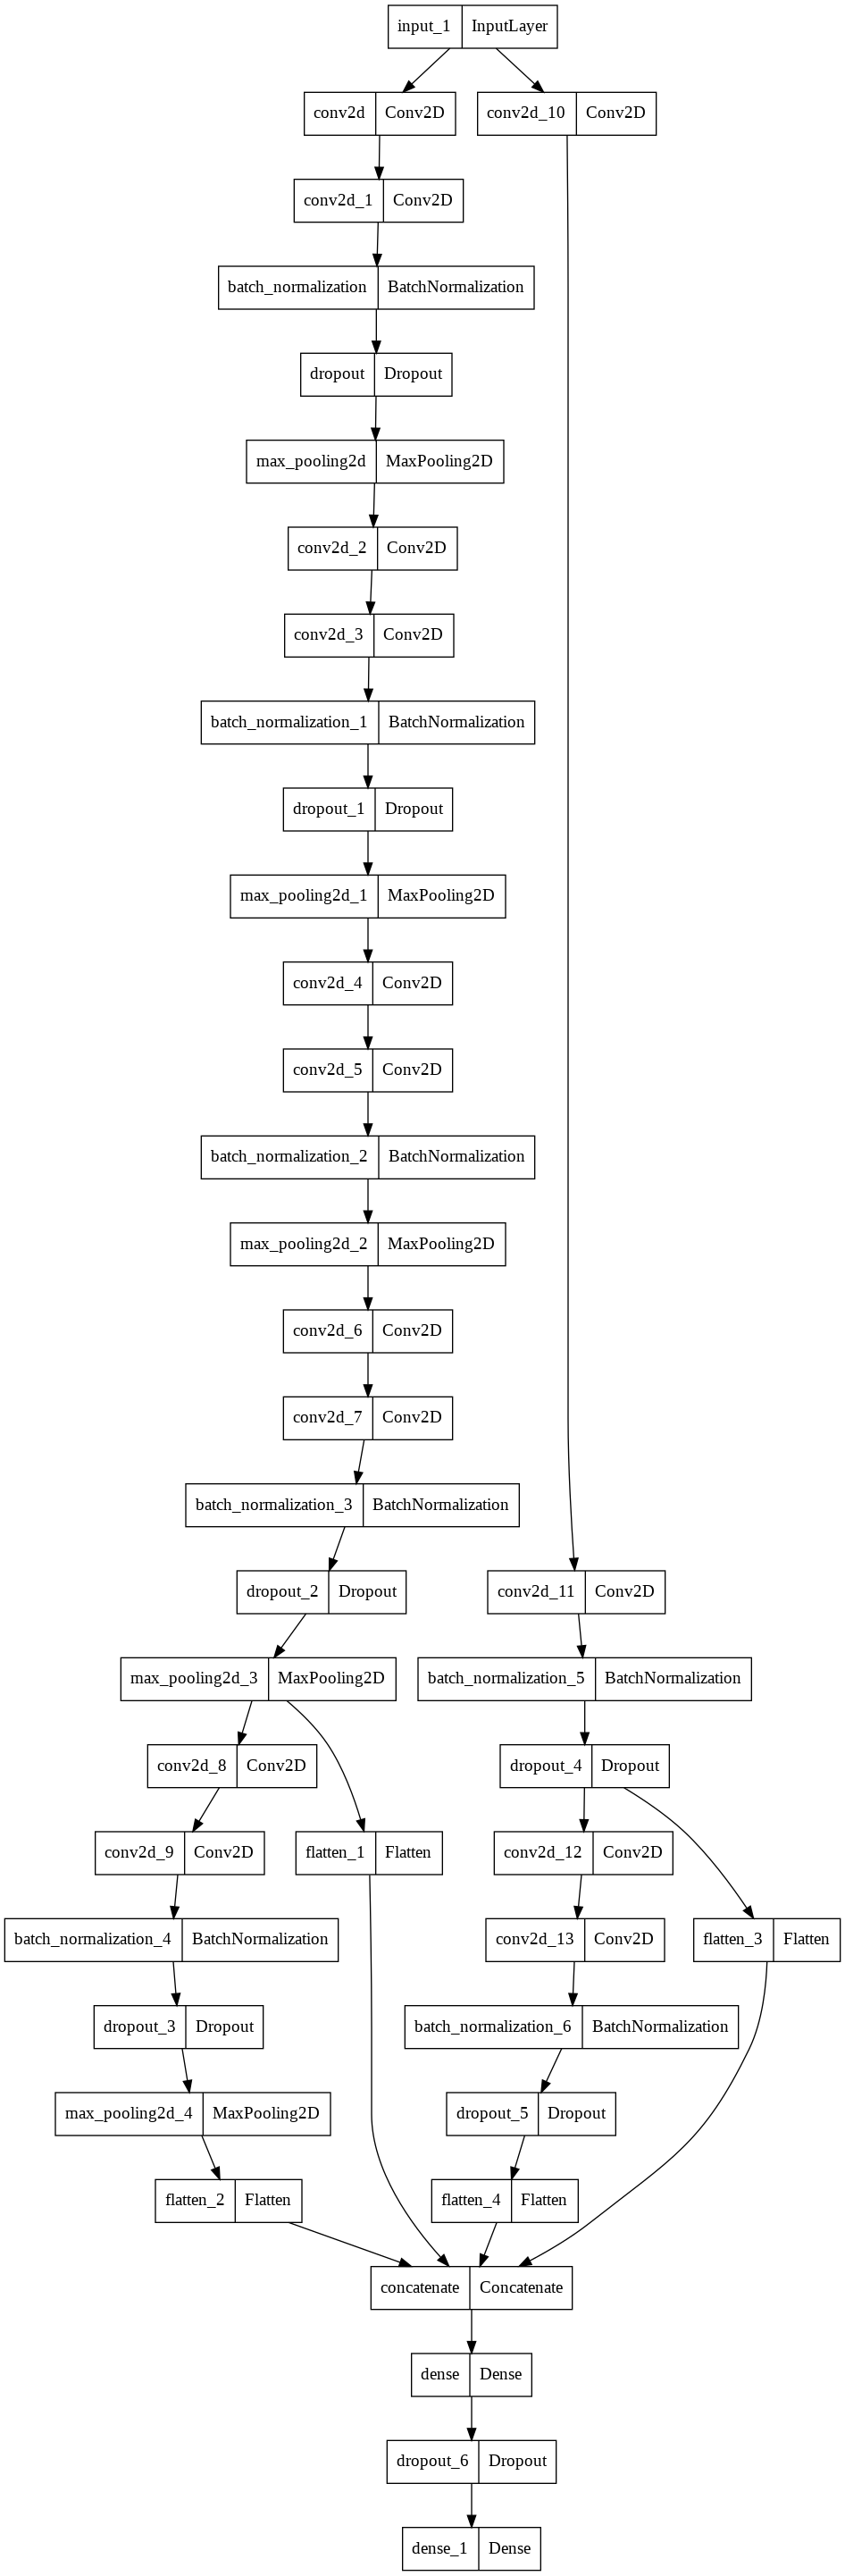

In [ ]:
plot_model(model)

In [ ]:
callbacks = [ModelCheckpoint(filepath='/content/drive/MyDrive/model71.h5',
             verbose=0, save_best_only=True, save_weights_only=False) ]

In [ ]:
history = model.fit(xTrain, yTrain, validation_data=(xTest,  yTest), epochs=5, callbacks=callbacks, batch_size=128)

Epoch 1/5
468/468 [==============================] - 65s 113ms/step - loss: 0.2178 - accuracy: 0.9766 - val_loss: 2.3264 - val_accuracy: 0.7266
Epoch 2/5
468/468 [==============================] - 49s 105ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 3.4973 - val_accuracy: 0.7388
Epoch 3/5
468/468 [==============================] - 49s 105ms/step - loss: 0.0232 - accuracy: 0.9956 - val_loss: 73.0809 - val_accuracy: 0.2852
Epoch 4/5
468/468 [==============================] - 51s 109ms/step - loss: 0.0162 - accuracy: 0.9972 - val_loss: 1.3283 - val_accuracy: 0.8561
Epoch 5/5
468/468 [==============================] - 49s 105ms/step - loss: 0.0212 - accuracy: 0.9971 - val_loss: 4.7555 - val_accuracy: 0.7679


In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 6
    if epoch % decay_step == 0 and epoch: lr *= 0.1

    return lr

callbacks = [ LearningRateScheduler(lr_scheduler, verbose=0),
              ModelCheckpoint(filepath='/content/drive/MyDrive/model71.h5',
              verbose=0, save_best_only=True, save_weights_only=False)  ]   

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=128, epochs=10, validation_data=(xTest, yTest),               
                      callbacks=[callbacks], verbose=1, shuffle=True)

Epoch 1/10
468/468 [==============================] - 65s 114ms/step - loss: 0.2359 - accuracy: 0.9734 - val_loss: 1.2229 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 2/10
468/468 [==============================] - 49s 105ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 5.1463 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 3/10
468/468 [==============================] - 51s 108ms/step - loss: 0.0197 - accuracy: 0.9955 - val_loss: 2.1631 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 4/10
468/468 [==============================] - 50s 108ms/step - loss: 0.0202 - accuracy: 0.9966 - val_loss: 0.1565 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 5/10
468/468 [==============================] - 49s 104ms/step - loss: 0.0116 - accuracy: 0.9981 - val_loss: 2.8283 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 6/10
468/468 [==============================] - 50s 107ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0242 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 7/10
468/468 [==============================] 

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=128, epochs=10, validation_data=(xTest, yTest),               
                      callbacks=[callbacks], verbose=1, shuffle=True)

Epoch 1/10
468/468 [==============================] - 63s 110ms/step - loss: 0.1834 - accuracy: 0.9780 - val_loss: 0.2088 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 2/10
468/468 [==============================] - 47s 101ms/step - loss: 0.0159 - accuracy: 0.9963 - val_loss: 1.6573 - val_accuracy: 0.7795 - lr: 0.0010
Epoch 3/10
468/468 [==============================] - 49s 105ms/step - loss: 0.0145 - accuracy: 0.9970 - val_loss: 0.0712 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 4/10
468/468 [==============================] - 48s 102ms/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 25.2272 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/10
468/468 [==============================] - 48s 102ms/step - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.6817 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 6/10
468/468 [==============================] - 48s 102ms/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 17.1697 - val_accuracy: 0.4827 - lr: 0.0010
Epoch 7/10
468/468 [==============================

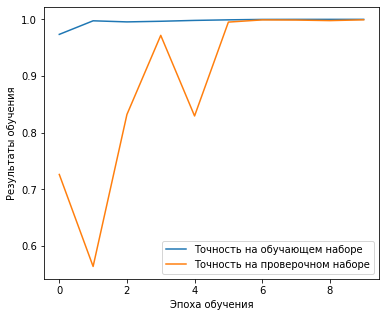

In [ ]:
def gplot(ghist):
  # ghist - history.history
  # График точности обучения
  plt.figure(figsize=(6, 5))
  plt.plot(ghist['accuracy'], label='Точность на обучающем наборе')    
  plt.plot(ghist['val_accuracy'], label='Точность на проверочном наборе')
  #plt.plot(ghist['loss'], label='Ошибка на обучающем наборе')    
  #plt.plot(ghist['val_loss'], label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Результаты обучения')
  plt.legend()
  plt.show()

gplot(history.history)  

Разбаланс по класам

In [ ]:
for cl in range(nClasses) :
  mask = np.argmax(yTest, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xTest[mask], yTest[mask])

0 bag
31/31 [==============================] - 1s 21ms/step - loss: 8.7927e-04 - accuracy: 1.0000
1 bal
53/53 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000
2 ban
17/17 [==============================] - 0s 23ms/step - loss: 3.0430e-05 - accuracy: 1.0000
3 bea
48/48 [==============================] - 1s 16ms/step - loss: 0.0085 - accuracy: 0.9967
4 can
60/60 [==============================] - 1s 15ms/step - loss: 0.0136 - accuracy: 0.9995
5 env
14/14 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000
6 gbt
18/18 [==============================] - 0s 22ms/step - loss: 3.5742e-09 - accuracy: 1.0000
7 mon
52/52 [==============================] - 1s 15ms/step - loss: 2.0777e-07 - accuracy: 1.0000
8 pbt
51/51 [==============================] - 1s 16ms/step - loss: 0.0115 - accuracy: 0.9957
9 toy
128/128 [==============================] - 2s 14ms/step - loss: 7.2325e-07 - accuracy: 1.0000


# Проверим на фото с интернета, камеры

In [ ]:
if os.path.exists('/content/check'): shutil.rmtree('/content/check')
! unzip -q /content/drive/MyDrive/dip/check.zip  # check.zip 

In [ ]:
class CheckLoader():
  def __init__(self, path):
    self.path = path
    self.clName = sorted(os.listdir(path))
    global xVal, yVal
    xVal, yVal = [],[]

  def loadImgFile(self, fPath):           # Загрузка изображения из файла
    return np.array(image.load_img(fPath, target_size=(71,71))).astype('float32')/255     # изображение .  

  def loadImages(self, ncl):              # Загрузка класса
      for n, imfile in enumerate(os.listdir(self.path + self.clName[ncl])):  #  для каждого изображения  
        img = self.loadImgFile(os.path.join(self.path + self.clName[ncl], imfile))
        img = (img - img.min()) / (img.max() - img.min() + 0.01)                     # contrast - max
        #for i in range(2,71): img[:,i,:] =img[:,i,:]/2 + img[:,i-1,:]/4 + img[:,i-2,:]/4

        xVal.append(np.array(img))          # добавим в список обуч.  
        yVal.append(ncl)
  
  def loadDataVal(self):      # Загрузка изображений
    for nc in range(len(self.clName)):
      self.loadImages(nc)     # загрузим избражениЯ
      print(self.clName[nc], end = '   ')
    return self.clName

In [ ]:
dl = CheckLoader('/content/check/')
className = dl.loadDataVal()
del dl
nClasses = len(className)
xVal = np.array(xVal)
yVal = utils.to_categorical(yVal, nClasses)   
print(xVal.shape, yVal.shape) 

bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (100, 71, 71, 3) (100, 10)


In [ ]:
n = 10 # Количество выводимых случайных картинок
fig, axs = plt.subplots(n, n, figsize=(24, 24)) # Создаем полотно из n*n графиков
for i in range(n): # Проходим по классам
  for j in range(n):
    axs[i,j].imshow(xVal[i*10+j]) # Отображаем фото
plt.show() # Показываем изображения  

In [ ]:
vAccuracy =[]
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на проверочной выборке
  mx = model.evaluate(xVal[mask], yVal[mask])
  vAccuracy.append(mx[1])

0 bag
1/1 [==============================] - 0s 227ms/step - loss: 104.5066 - accuracy: 0.1000
1 bal
1/1 [==============================] - 0s 38ms/step - loss: 20.1629 - accuracy: 0.3000
2 ban
1/1 [==============================] - 0s 36ms/step - loss: 48.9943 - accuracy: 0.3000
3 bea
1/1 [==============================] - 0s 45ms/step - loss: 2.5640 - accuracy: 0.8000
4 can
1/1 [==============================] - 0s 42ms/step - loss: 36.0944 - accuracy: 0.3000
5 env
1/1 [==============================] - 0s 29ms/step - loss: 39.4729 - accuracy: 0.2000
6 gbt
1/1 [==============================] - 0s 31ms/step - loss: 30.9011 - accuracy: 0.1000
7 mon
1/1 [==============================] - 0s 30ms/step - loss: 67.2919 - accuracy: 0.0000e+00
8 pbt
1/1 [==============================] - 0s 37ms/step - loss: 53.4880 - accuracy: 0.1000
9 toy
1/1 [==============================] - 0s 30ms/step - loss: 4.4360 - accuracy: 0.7000


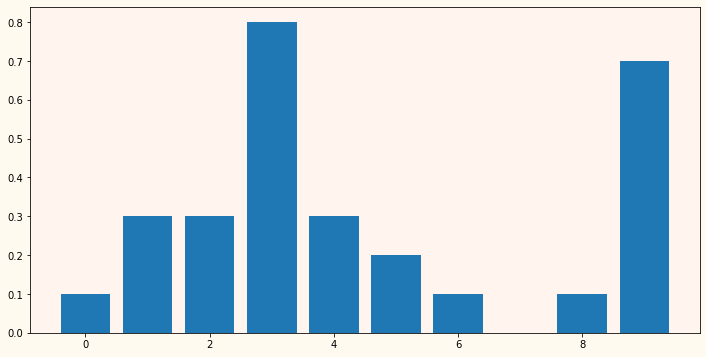

In [ ]:

fig, ax = plt.subplots()
x = [i for i in range(nClasses)]
ax.bar(x, vAccuracy)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

# Выводы:

1. Присутствует неравномерное распределение примеров по категориям.

2. Сеть распознает примеры из валидационной выборки очень хорошо.

3. Распознавания изображений из интернета или камеры - практически нет.


# Принято решение:

1. Провести аугментацию данных

2. Добавить в обучающую выборку примеры(50-100 на категорию), из интернета или камеры.

3. Оптимизировать архитектуру сети с помощью генетического алгоритма.




#    	   Методы аугментации.


1.     	Индивидуальная обработка по категориям :

*   изменение цвета предмета cлучайным образом (отбор предмета по цвету)
*   случайное изменение цвета всего изображения.
*   поворот на 90 градусов
*   размытие
*   зашумление






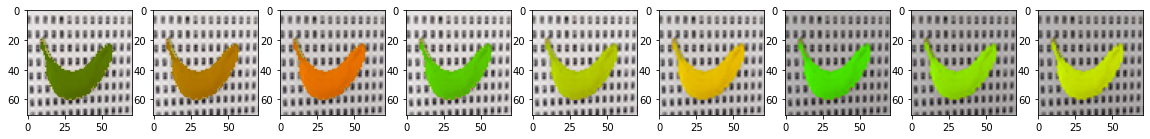

In [ ]:
#im = image.load_img('/content/images/can/35240.png')
im = image.load_img('/content/images/ban/27590.png') 
mgreens= [0.6, 1.0, 1.4]     #1. + 0.25* random.random()  # 0.25 + random.random() 
mreds=  [0.4,  0.8, 1.1]     #1. + 0.25* random.random()   # 0.25 + random.random()

fig, axs = plt.subplots(1, 9, figsize=(20, 2)) # Создаем полотно из n графиков
n=0 
for mgreen in mgreens:
  for mred in mreds:
      img = np.array(im).astype('float32')

      mask = (img[:,:,2] < 140) & (img[:,:,0] > 150) & (img[:,:,1] > 100) 
      img[mask,0] *= mred  # Red     
      img[mask,1] *= mgreen   # Green 
      img[mask,2]  = 0

      img = (img - img.min()) *255/(img.max()- img.min()+1)
 
      axs[n].imshow(img/255) # Отображаем фото
      n +=1 

plt.show() # Показываем изображения

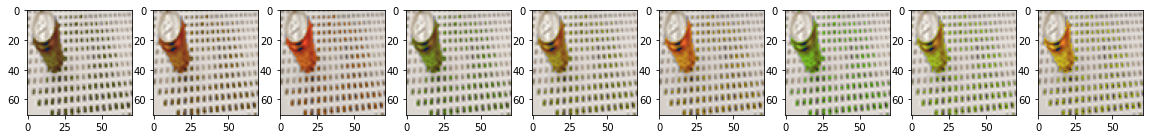

In [ ]:
im = image.load_img('/content/images/can/35240.png')

mgreens= [0.8, 1.1, 1.4]     #1. + 0.25* random.random()  # 0.25 + random.random() 
mreds=  [0.8,  1.1, 1.4]     #1. + 0.25* random.random()   # 0.25 + random.random()

fig, axs = plt.subplots(1, 9, figsize=(20, 2)) # Создаем полотно из n графиков
n=0 
for mgreen in mgreens:
  for mred in mreds:
      img = np.array(im).astype('float32')

      mask = (img[:,:,2] > 70) & (img[:,:,0] < 120) & (img[:,:,1] < 180)
      img[mask,0] = img[mask,2] * mred  # Red 
      img[mask,1] *= mgreen               # Green 
      img[mask,2]  /= 4

      img = (img - img.min()) *255/(img.max()- img.min()+1)
 
      axs[n].imshow(img/255) # Отображаем фото
      n +=1 

plt.show() # Показываем изображения

# Подготовка данных

Подгрузим дополнительные снимки

In [ ]:
if os.path.exists('/content/addons'): shutil.rmtree('/content/addons')
!unzip -q /content/drive/MyDrive/dip/addons.zip 



*   Для использования в генетическом алгоритме отберем часть данных (128*6)

 для каждого класса (равномерно по длине класса).
*   Оставшиеся направим в тестовую выборку, для финальной проверки
*   Проведем аугментацию и добавим дополнительные данные.


In [ ]:
class DataMaker():
  def __init__(self, path):
    self.path = path
    self.clName = sorted(os.listdir(path))    
    if os.path.exists(testPath): shutil.rmtree(testPath)
    os.mkdir(testPath) 
    if os.path.exists(trainPath): shutil.rmtree(trainPath)
    os.mkdir(trainPath) 

  def loadImgFile(self, fPath):           # Загрузка изображения из файла
    return np.array(image.load_img(fPath, target_size=(71,71))).astype('float32')   

  def addImages(self, ncl):   
    for imfile in os.listdir(addPath + self.clName[ncl]):  
      img = self.loadImgFile(os.path.join(addPath + self.clName[ncl], imfile))
      img = (img - img.min()) *255/(img.max()- img.min()+1)                     # contrast - max
      image.save_img(os.path.join(trainPath + self.clName[ncl], imfile), img) 

  def copyImages(self, ncl):                    # Загрузка класса
    lPath = self.path + self.clName[ncl]
    hit = 0                                     # Счетчик загруженных файлов
    k = datalen/len(os.listdir(lPath))          # data len
    for n, imfile in enumerate(os.listdir(lPath)):  
      if n*k < hit : 
        shutil.copy(os.path.join(lPath, imfile), os.path.join(testPath + self.clName[ncl], imfile) )       
        continue   # прорехивание:  у= кх,   hit = k*n ;   k=2000/N
      hit += 1  
      img = self.loadImgFile(os.path.join(lPath, imfile)) 
      if (random.randint(0,1)) :                                                # 1/2 файлов подвергается цветовой аугментации
        if ncl in [0, 6]  :                                                     # bag, gbt   
          mask = (img[:,:,0] < 100) & (img[:,:,1] < 100) & (img[:,:,2] < 100)      
          img[mask,0] *= (0.6 + random.random()) # Red 
          img[mask,1] *= (1.2 + random.random()) # Green 
          img[mask,2] *= (0.8 + random.random()) # blue

        if ncl == 1:                                                            # bal 
          mask = (img[:,:,2] < 140) & (img[:,:,0] > 130) & (img[:,:,1] > 130)
          mlt =  (1 + 0.1 * random.random())    # multyplier 
          img[mask,0] *= mlt/1.2                 # Red     
          img[mask,1] *= mlt                     # Green

        if ncl == 2 :                                                           # ban      
          mask = (img[:,:,2] < 140) & (img[:,:,0] > 150) & (img[:,:,1] > 100) 
          img[mask,0] *= (0.4 +  0.7 * random.random()) # Red     
          img[mask,1] *= (0.6 + 0.8 * random.random())  # Green 
          img[mask,2]  = 0

        if ncl in [4, 8, 9] :                                                   # can, pbt, toy
          mask = (img[:,:,2] > 70) & (img[:,:,0] < 120) & (img[:,:,1] < 180)
          img[mask,0] = img[mask,2] * (0.8 +  0.6*random.random())  # Red 
          img[mask,1] *= (0.8 + 0.6*random.random())               # Green 
          img[mask,2]  /= 4

        if ncl in [3, 5, 7] : 
          img[:,:, hit%3] *= (0.7 + 0.7*random.random())                        # bea, env, mon - вирирование   

      if hit%2  :                                                               
        if (random.randint(0,1)) :  
          for color in [0,1,2] : img[:,:,color] = img[:,:,color].transpose()     # поворот на 90 градусов
        else:
          for i in range(2,71): 
            img[:,i,:] =img[:,i,:]/2 + img[:,i-1,:]/4 + img[:,i-2,:]/4          # размытие                                        
        
      img[:,:, hit%3] += (64 * np.random.random((71, 71)) - 32)                 # небольшое зашумление 

      img = (img - img.min()) *255/(img.max()- img.min()+1)                     # contrast - max
      image.save_img(os.path.join(trainPath + self.clName[ncl], imfile), img)   # При записи img переводится в uint8

  def makeDataSet(self):      # Загрузка изображений
    for nc in range(len(self.clName)):
      os.mkdir(trainPath + self.clName[nc])
      os.mkdir(testPath + self.clName[nc])
      if os.path.exists(addPath): self.addImages(nc)  
      self.copyImages(nc)     # загрузим избражениЯ
      print(self.clName[nc], end = '   ')

    return self.clName

path = '/content/images/'
addPath = '/content/addons/'
trainPath = '/content/train/'
testPath = '/content/test/'
datalen = 128*6

dl = DataMaker(path)
print('Поехали:') 
className = dl.makeDataSet()
del dl

nClasses = len(className)

Поехали:
bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   

Сохраним для следующих экспериментрв

In [ ]:
!tar -cf /content/drive/MyDrive/train.tar /content/train
!tar -cf /content/drive/MyDrive/test.tar /content/test

In [ ]:
!tar -xf /content/drive/MyDrive/train.tar -C /     # загрузка обучающей

In [ ]:
!tar -xf /content/drive/MyDrive/test.tar -C /     # загрузка проверочной-финальной

Загрузим полученный датасет

In [ ]:
class DsetLoader():
  def __init__(self, path):
    self.path = path
    self.clName = sorted(os.listdir(path))  

  def loadImages(self, ncl):              # Загрузка класса
    for n, imf in enumerate(os.listdir(self.path + self.clName[ncl])): 
      img = np.array(image.load_img(os.path.join(self.path + self.clName[ncl], imf), target_size=(71,71)))
      xTrain.append(img)          # добавим в список обуч.  
      yTrain.append(ncl)

  def loadDset(self):      # Загрузка изображений
    for nc in range(len(self.clName)):
      self.loadImages(nc)     # загрузим избражениЯ
      print(self.clName[nc], end = '   ')
    return self.clName

xTrain, yTrain = [],[]

dl = DsetLoader('/content/train/')
className = dl.loadDset()
del dl

nClasses = len(className)
xTrain = np.array(xTrain).astype('float32')/255
yTrain = utils.to_categorical(yTrain, nClasses)
print(xTrain.shape, yTrain.shape)
for cl in range(nClasses) :
  mask = np.argmax(yTrain, axis=1) == cl    # Маска на класс
  print(mask[mask].shape[0], end='   ')  


bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (8584, 71, 71, 3) (8584, 10)
818   896   896   823   896   801   896   858   896   804   

Результаты аугментации и обогащения данных:

In [ ]:
n = 10 # Количество выводимых случайных картинок
fig, axs = plt.subplots(n, 2*n, figsize=(24, 12)) # Создаем полотно из n*2n графиков
for i in range(n): # Проходим по классам
  label_indexes = np.where(np.argmax(yTrain, axis=1)==i%10)[0] # Получаем список из индексов положений класса i в y_train
  for j in range(n*2):
    indx = random.choice(label_indexes) # Случайным образом выбираем из списка индекс
    axs[i,j].imshow(xTrain[indx]) # Отображаем фото
plt.show() # Показываем изображения  

# 2. Настройка модели с помошью ГА

Функция создания сети по заданным параметрам

In [ ]:
def createConvNet(net):
    # Список параметров
    makeBranch1  =   net[0]           # Делаем ли 1-ю ветвь  strides = 2
    nnFactor1 = 2 ** net[1]           # множитель нейронов
    nnIncrease1 = 2**(net[2]/2)       # увеличение нейронов по слоям:  0-1; 1-V`2; 2-2 
    makeLastConv1 =  net[3]           # Делаем ли последнюю свертку+спулинг

    makeBranch2  =   net[4]           # Делаем ли 2-ю ветвь  strides = 4
    nnFactor2 = 2 ** net[5]           # множитель нейронов
    nnIncrease2 = int(4**(net[6]/2))  # увеличение нейронов по слоям 0 -1; 1-V`Nmxpoll; 2- Nmxpoll
    makeLastConv2 =  net[7]           # Делаем ли последнюю свертку+спулинг

    makeBranch3  =   net[8]           # Делаем ли 3-ю ветвь  strides = 8
    nnFactor3 = 2 ** net[9]           # множитель нейронов
    nnIncrease3 = int(8**(net[10]/2)) # увеличение нейронов по слоям 1-2; 2- Nmxpoll
    makeLastConv3 =  net[11]          # Делаем ли последнюю свертку+спулинг

    inpBatchNorm   =  net[12]         # Делаем ли inp BatchNorm
    sizeDropout = 0.25+0.15*net[13]   # sizeDropout
    denseSize  = 2 ** net[14]         # Размер полносвязного слоя  512 + 128 *n

    shape = (71,71,3 )                # Размер входных данных
    toConcat = []                     # Этот список будем потом склеивать

    if (makeBranch1+makeBranch2+makeBranch3)== 0:  makeBranch2 = 1

    modelInput = Input(shape)          # Входной слой
    x = modelInput
    if (inpBatchNorm) : x = BatchNormalization()(modelInput)

    def convMaxp(nn, kernel,x):
      x = Conv2D(nn, kernel+1, padding="same", activation="relu")(x)
      x = Conv2D(nn, kernel+1, padding="same", activation="relu")(x)
      x = BatchNormalization()(x)
      x = Dropout(sizeDropout)(x)
      return MaxPooling2D(kernel)(x)

    if (makeBranch1) :
      x1 = convMaxp(nnFactor1, 2, x)          # для 1-й ветви  kernel = 2
      x1 = convMaxp(nnFactor1 * int(nnIncrease1), 2, x1)
      x1 = convMaxp(nnFactor1 * int(nnIncrease1 **2), 2, x1)
      x1 = convMaxp(nnFactor1 * int(nnIncrease1 **3), 2, x1)
      flat1 = Flatten()(x1)
      toConcat.append(flat1)  # Добавляем в список
      if (makeLastConv1) :
        x1 = convMaxp(nnFactor1 * int(nnIncrease1 **4), 2, x1)
        x1 = Flatten()(x1)
        toConcat.append(x1)  # Добавляем в список

    if (makeBranch2) :
      x2 = convMaxp(nnFactor2, 4, x)           # для 2-й ветви kernel = 4
      x2 = convMaxp(nnFactor2 * nnIncrease2, 4, x2)
      flat2 = Flatten()(x2)
      toConcat.append(flat2)  # Добавляем в список
      if (makeLastConv2) :
        x2 = convMaxp(nnFactor2 * nnIncrease2 **2, 4, x2)
        x2 = Flatten()(x2)
        toConcat.append(x2)  # Добавляем в список

    if (makeBranch3) :
      x3 = convMaxp(nnFactor3, 16, x)           # для 2-й ветви kernel = 16 and 4
      flat3 = Flatten()(x3)
      toConcat.append(flat3)  # Добавляем в список
      if (makeLastConv3) :
        x3 = convMaxp(nnFactor3 * nnIncrease3, 4, x3)
        x3 = Flatten()(x3)
        toConcat.append(x3)  # Добавляем в список
   
    # Объедияем блоки
    if len(toConcat) > 1:     fin = concatenate(toConcat)
    elif len(toConcat) == 1:  fin = toConcat[0]

    # Полносвязные слои на выходе
    x = Dense(512+denseSize*128 , activation='relu')(fin)
    x = Dropout(sizeDropout)(x)

    x = Dense(nClasses, activation='softmax')(x)

    model = Model(modelInput, x)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model                # Возвращаем моель

def lr_scheduler(epoch, lr):
    decay_step = 5
    if epoch % decay_step == 0 and epoch: lr *= 0.1

    return lr

def evaluateNet(net, ep, verb):
  # Вычисление результата работы сети
  model = createConvNet(net)  # Создаем и обучаем модель 
  history = model.fit(xTrain, yTrain, batch_size=50, epochs=ep, validation_data=(xVal, yVal),                   
                      callbacks=[LearningRateScheduler(lr_scheduler, verbose=0)], verbose=0, shuffle=True)

  return history.history["val_loss"][-1] # Возвращаем ошибку на проверочной выборке с последней эпохи

def createRandomNet():
    # Создание списка случайных параметров
    net = []
    net.append(random.randint(0,1))   # Делаем ли 1-ю ветвь  strides = 2
    net.append(random.randint(1,3))   # множитель нейронов
    net.append(random.randint(0,2))   # увеличение нейронов по слоям  0-1; 1-V`2; 2- 2
    net.append(random.randint(0,1))   # Делаем ли последнюю свертку+спулинг

    net.append(random.randint(0,1))   # Делаем ли 2-ю ветвь  strides = 4
    net.append(random.randint(1,3))   # множитель нейронов
    net.append(random.randint(0,2))   # увеличение нейронов по слоям 0 -1; 1-V`Nmxpoll; 2- Nmxpoll
    net.append(random.randint(0,1))   # Делаем ли последнюю свертку+спулинг

    net.append(random.randint(0,1))   # Делаем ли 3-ю ветвь  strides = 16
    net.append(random.randint(1,3))   # множитель нейронов
    net.append(random.randint(0,2))   # увеличение нейронов по слоям 0 -1; 1-V`Nmxpoll; 2- Nmxpoll
    net.append(random.randint(0,1))   # Делаем ли последнюю свертку+спулингг

    net.append(random.randint(0,1))   # Делаем ли in Bn
    net.append(random.randint(0,1))   # sdr
    net.append(random.randint(0,3))   # Размер полносвязного слоя  512 + 128 * 2**n

    return net

Проверим работу функции создания модели

In [ ]:
model = createConvNet([0,0,0,0, 0,0,0,0, 0,0,0,0,  0,0,0])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 1)         76        
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 1)         26        
                                                                 
 batch_normalization_5 (Batc  (None, 71, 71, 1)        4         
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 71, 71, 1)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 1)        0         
 2D)                                                       

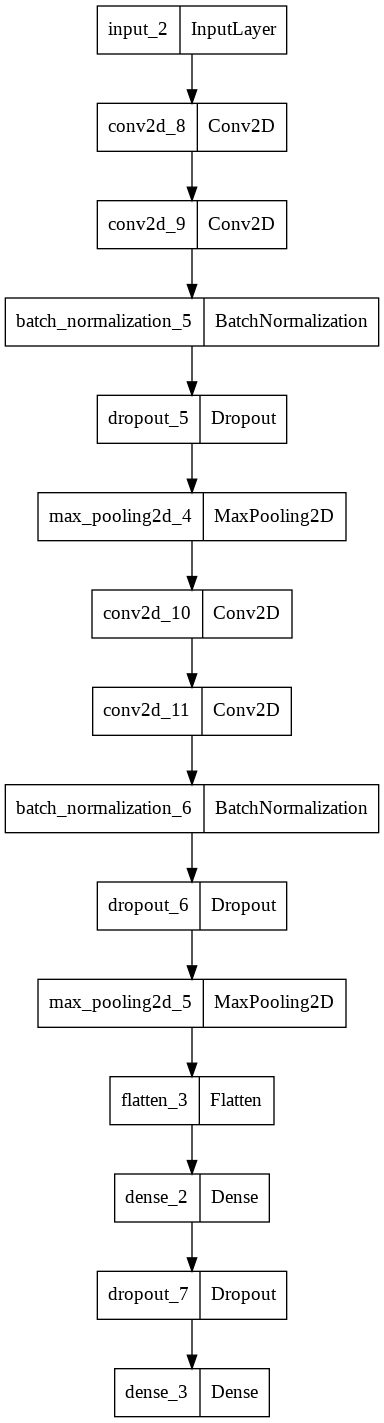

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model = createConvNet([0,3,1,1, 1,1,2,0, 1,2,1,1,  1,0,3])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 71, 71, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 71, 71, 2)    152         ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_4 (Conv2D)              (None, 71, 71, 4)    3472        ['batch_normalization[0][0]']

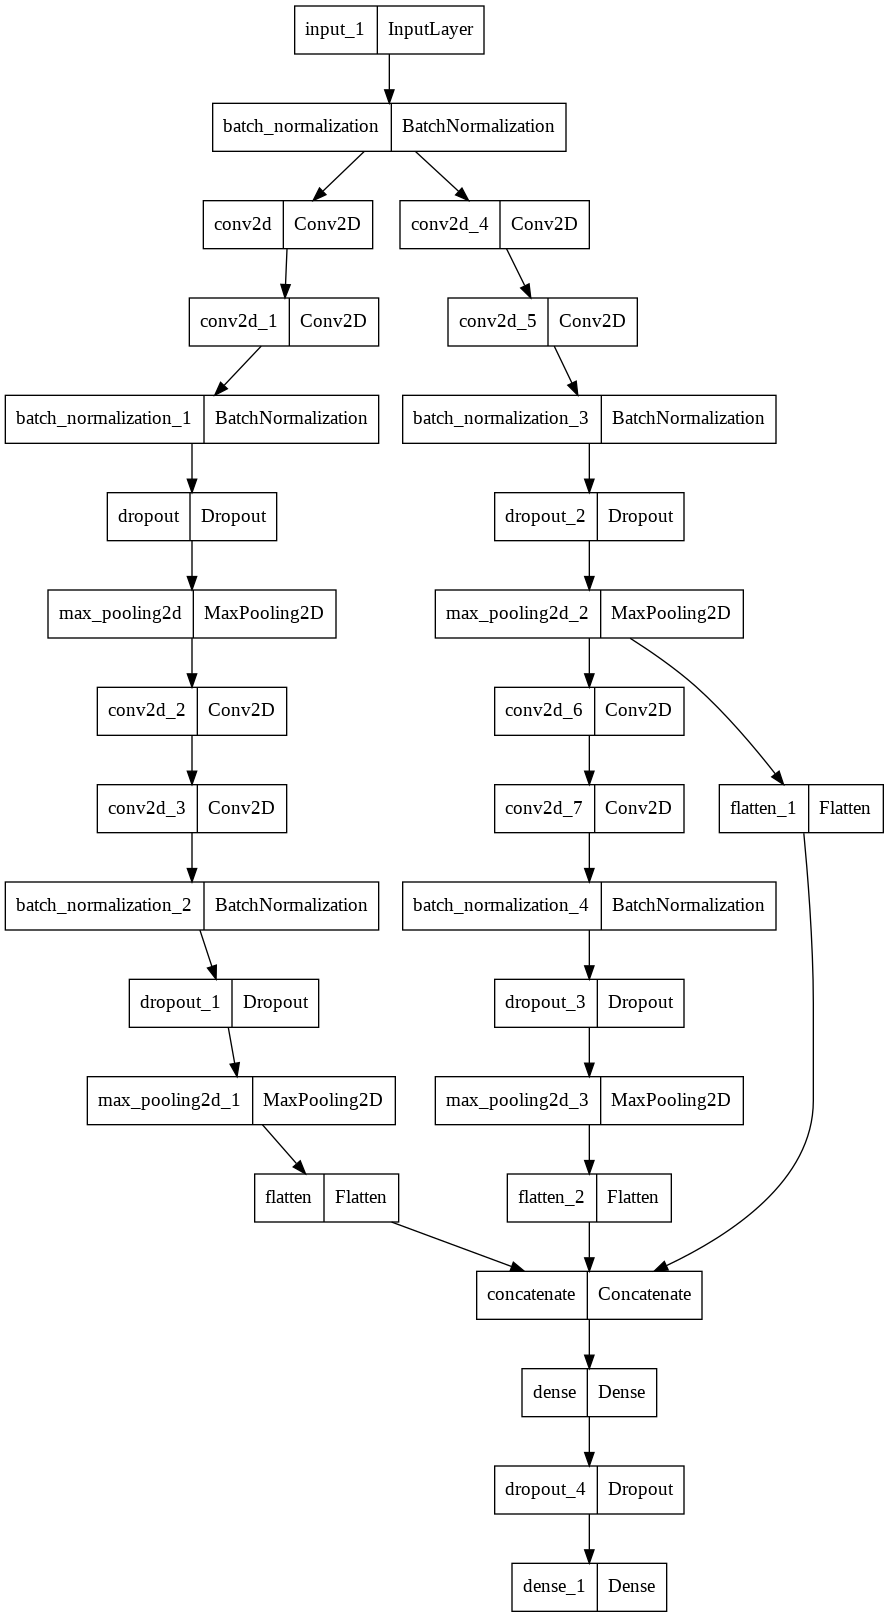

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Генетический алгоритм

*   На первом этапе зададим начальные параметры 9-ти ботов методом планирования эксперимента

 с использованием Греко-латинского квадрата.
*   Таким образом будут представлены все уровни параметров. 
*   В качестве валидационной выборки используем фото из интернета / камеры.


In [ ]:
# Генетический алгоритм
n = 16                    # Общее число ботов > 9
nsurv = 6                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых                   G/L Square
lbot = 15                 # Размер бота                       00   11   22  
epohs = 6                 # количество эпох                   12   20   01     
mut = 0.4                 # коэфициент мутаций                21   02   10                                           
popul = []                # Массив популяции                      
val = []                  # Одномерный массив значений ботов

# Создаём ботов        4        8        12       
popul.append([0,1,0,0, 1,1,0,1, 1,1,0,0, 1,0,0])      #   branch    lowBlock    
popul.append([0,2,1,0, 1,2,1,1, 1,2,1,1, 0,1,1])      #  \        0     1     1/0                 
popul.append([0,3,2,0, 1,3,2,1, 1,3,2,1, 1,0,2])      #    011    10    21    32   neurons[1,3], increase [0,2]
                                                       
popul.append([1,2,2,0, 1,2,2,1, 0,2,2,0, 0,1,1])      #    110    22    30    11
popul.append([1,3,0,0, 1,3,0,1, 0,3,0,1, 1,0,2])      #           
popul.append([1,1,1,0, 1,1,1,1, 0,1,1,0, 0,1,0])      #    101    31    12    20

popul.append([1,3,1,0, 0,3,1,1, 1,3,1,0, 1,0,2])      #   /
popul.append([1,1,2,0, 0,1,2,1, 1,1,2,1, 0,1,0])      # .
popul.append([1,2,0,0, 0,2,0,1, 1,2,0,1, 1,0,1])      # 

for i in range(n-9):  popul.append(createRandomNet())
  
for it in range(epohs):   # Пробегаем по всем эпохам
  val = []                # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):      # Пробегаем в цикле по всем ботам 
    bot = popul[i]        # Берем очередного бота

    # Вычисляем точность текущего бота
    f = evaluateNet(bot, 7, 0) 
    val.append(f)         # Добавляем полученное значение в список val

  # Сортируем val
  sval = sorted(val, reverse=0) 

  # Выводим 3 лучших ботa
  print(it,(time.time()-curr_time)//60, " ", '%.4f' %sval[0], '%.4f' %sval[1], '%.4f' %sval[2],  popul[:3]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1-го родителя от 0 до nsurv-1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс 2-го родителя от 0 до nsurv-1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового     
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(lbot ):              # Пробегаем по всей длине размерности бота      
      #x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      if pindex < 0.5:          x = botp1[j]    # Если < 0.5 - берем значения от 1-го бота
      else:                     x = botp2[j]    # иначе от второго
      
      if (random.random() < mut): x = net4Mut[j]    # устанавливаем значение бота из net4Mut
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую  популяцию

0 16.0   0.7292 0.7295 0.7704 [[0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0], [0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1], [0, 3, 2, 0, 1, 3, 2, 1, 1, 3, 2, 1, 1, 0, 2]]
1 19.0   0.3784 0.4385 0.4483 [[0, 2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 2], [0, 3, 2, 0, 1, 3, 2, 1, 1, 3, 2, 1, 1, 0, 2], [1, 2, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 1, 0, 1]]
2 19.0   0.3021 0.3501 0.4931 [[1, 3, 1, 0, 0, 3, 1, 1, 1, 3, 1, 0, 1, 0, 2], [1, 2, 1, 0, 0, 1, 0, 1, 1, 3, 1, 0, 1, 1, 2], [1, 1, 1, 0, 0, 2, 0, 0, 1, 3, 0, 1, 1, 0, 2]]
3 21.0   0.2772 0.3674 0.3862 [[1, 1, 1, 0, 0, 2, 0, 0, 1, 3, 0, 1, 1, 0, 2], [1, 1, 1, 0, 0, 2, 0, 1, 1, 3, 0, 1, 1, 0, 2], [0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0]]
4 17.0   0.2934 0.4157 0.5493 [[1, 1, 0, 0, 0, 2, 0, 1, 1, 3, 0, 0, 1, 0, 3], [1, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1], [1, 1, 1, 0, 0, 2, 0, 1, 1, 3, 0, 1, 1, 0, 2]]
5 20.0   0.2448 0.3875 0.4141 [[1, 1, 0, 0, 0, 2, 0, 1, 1, 3, 0, 0, 1, 0, 3], [1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2], [1, 2, 0, 0, 0,

На втором этапе начнем с наиболее удачных ботов

In [ ]:
popul = []                # Массив популяции                      
val = []                  # Одномерный массив значений ботов

# Создаём ботов        4           8           12       
popul.append([0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 2])      #      
popul.append([1, 1, 2, 0, 1, 2, 2, 1, 1, 3, 2, 1, 0, 0, 0])      #                  
popul.append([0, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 1, 1, 0, 2])      #    

for i in range(n-3):  popul.append(createRandomNet())
  
for it in range(epohs):   # Пробегаем по всем эпохам
  val = []                # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):      # Пробегаем в цикле по всем ботам 
    bot = popul[i]        # Берем очередного бота

    # Вычисляем точность текущего бота
    f = evaluateNet(bot, 7, 0) 
    val.append(f)         # Добавляем полученное значение в список val

  # Сортируем val
  sval = sorted(val, reverse=0) 

  # Выводим 3 лучших ботa
  print(it,(time.time()-curr_time)//60, " ", '%.4f' %sval[0], '%.4f' %sval[1], '%.4f' %sval[2],  popul[:3]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1-го родителя от 0 до nsurv-1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс 2-го родителя от 0 до nsurv-1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового     
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(lbot ):              # Пробегаем по всей длине размерности бота      
      #x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      if pindex < 0.5:          x = botp1[j]    # Если < 0.5 - берем значения от 1-го бота
      else:                     x = botp2[j]    # иначе от второго
      
      if (random.random() < mut): x = net4Mut[j]    # устанавливаем значение бота из net4Mut
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую  популяцию

0 17.0   0.2619 0.2652 0.3405 [[0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 2], [1, 1, 2, 0, 1, 2, 2, 1, 1, 3, 2, 1, 0, 0, 0], [0, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 1, 1, 0, 2]]
1 19.0   0.2120 0.2491 0.2646 [[0, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 1, 1, 0, 2], [1, 2, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 0, 3], [0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 2]]
2 19.0   0.2408 0.2849 0.3097 [[1, 2, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3], [0, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 1, 1, 0, 2], [0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 2]]
3 18.0   0.2191 0.2231 0.2257 [[0, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 0, 1, 0, 3], [0, 3, 0, 0, 1, 3, 0, 0, 1, 3, 0, 1, 1, 0, 3], [1, 2, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3]]
4 24.0   0.1665 0.2124 0.2593 [[0, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 0, 1, 0, 3], [1, 2, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3], [0, 3, 0, 0, 1, 3, 0, 0, 1, 3, 0, 1, 1, 0, 3]]
5 17.0   0.2199 0.2507 0.2905 [[1, 1, 0, 0, 1, 1, 1, 0, 1, 3, 0, 1, 1, 0, 0], [0, 2, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3], [0, 3, 1, 0, 1,

# Финальная версия сети

In [ ]:
model = createConvNet([1, 1, 0, 0, 1, 1, 1, 0, 1, 3, 0, 1, 1, 0, 0])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 71, 71, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 71, 71, 2)    56          ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 71, 71, 2)    38          ['conv2d[0][0]']             

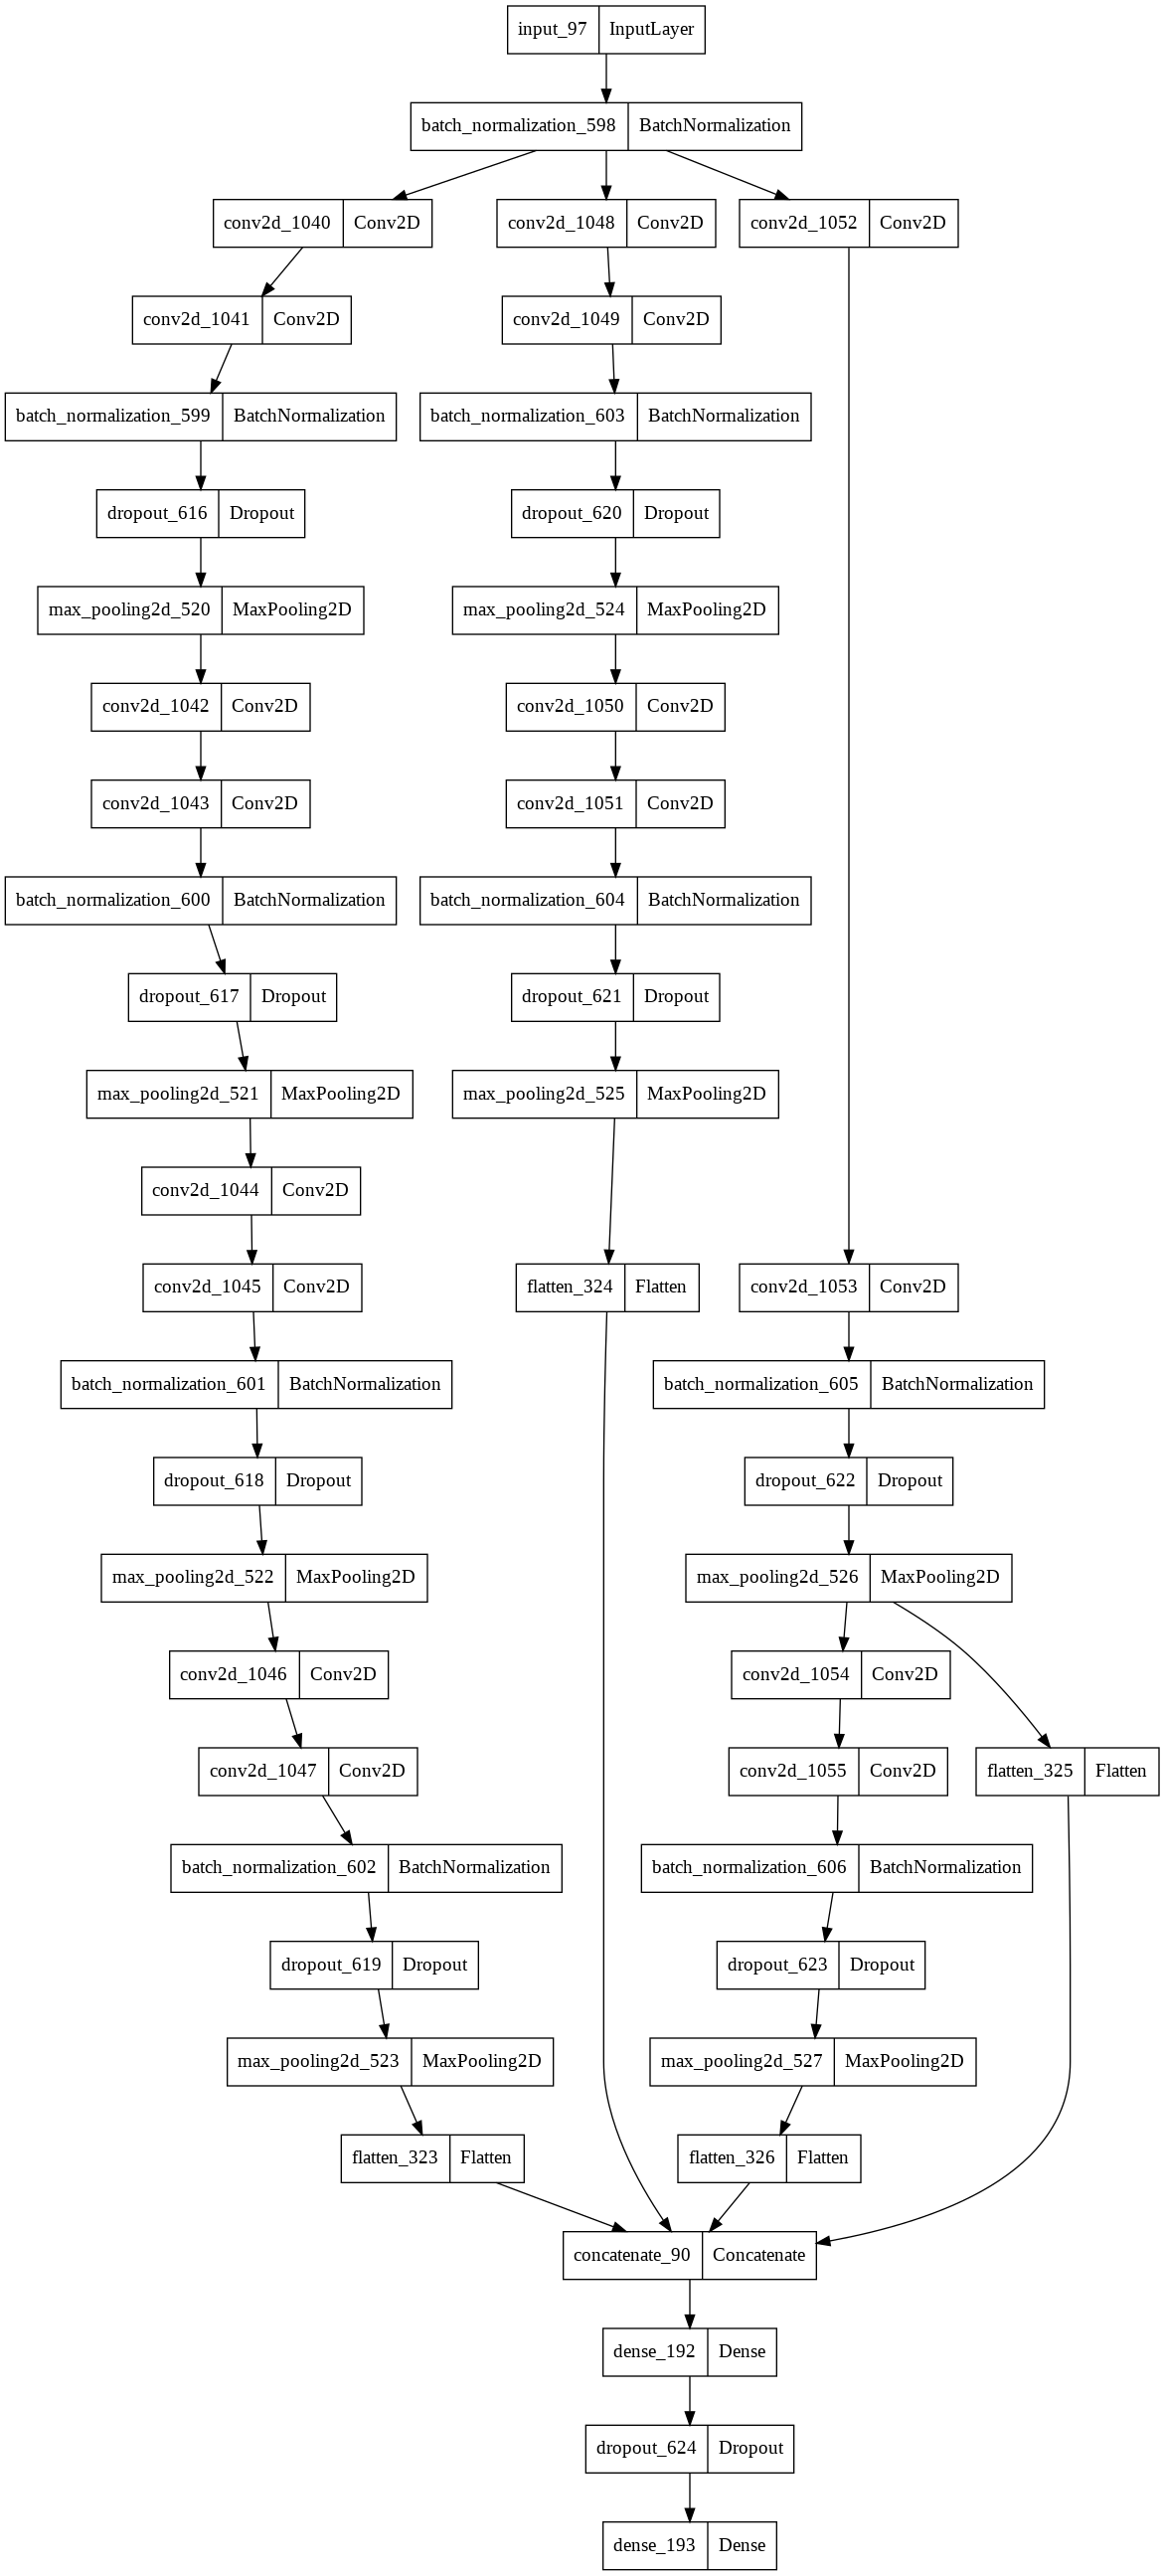

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Обучение

In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 6
    if epoch % decay_step == 0 and epoch: lr *= 0.1

    return lr

callbacks = [ LearningRateScheduler(lr_scheduler, verbose=0),
              ModelCheckpoint(filepath='/content/drive/MyDrive/mga3.h5',
              verbose=0, save_best_only=True, save_weights_only=False)  ]   

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=40, epochs=10, validation_data=(xVal, yVal),               
                      callbacks=[callbacks], verbose=1, shuffle=True)

Epoch 1/10
215/215 [==============================] - 18s 69ms/step - loss: 1.1852 - accuracy: 0.6407 - val_loss: 1.4271 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 13s 59ms/step - loss: 0.3771 - accuracy: 0.8809 - val_loss: 0.9321 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 13s 60ms/step - loss: 0.2296 - accuracy: 0.9292 - val_loss: 0.5940 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 13s 59ms/step - loss: 0.1443 - accuracy: 0.9511 - val_loss: 0.5606 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0970 - accuracy: 0.9705 - val_loss: 0.5044 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0740 - accuracy: 0.9780 - val_loss: 0.4537 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 7/10
215/215 [==============================] - 13s 

# Разбаланс по классам

In [ ]:
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

0 bag
1/1 [==============================] - 0s 290ms/step - loss: 0.1050 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 34ms/step - loss: 0.1130 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 35ms/step - loss: 0.0168 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 34ms/step - loss: 0.1158 - accuracy: 0.9000
4 can
1/1 [==============================] - 0s 40ms/step - loss: 0.4968 - accuracy: 0.9000
5 env
1/1 [==============================] - 0s 34ms/step - loss: 0.0871 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 36ms/step - loss: 0.0686 - accuracy: 1.0000
7 mon
1/1 [==============================] - 0s 39ms/step - loss: 0.0066 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 38ms/step - loss: 0.2620 - accuracy: 0.9000
9 toy
1/1 [==============================] - 0s 36ms/step - loss: 0.5468 - accuracy: 0.8000


# Дообучение

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=40, epochs=10, validation_data=(xVal, yVal),     # дообучение       
                      callbacks=[callbacks], verbose=1, shuffle=True)

Epoch 1/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0185 - accuracy: 0.9958 - val_loss: 0.1729 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 2/10
215/215 [==============================] - 12s 54ms/step - loss: 0.0190 - accuracy: 0.9956 - val_loss: 0.1775 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 3/10
215/215 [==============================] - 12s 54ms/step - loss: 0.0169 - accuracy: 0.9964 - val_loss: 0.1869 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 4/10
215/215 [==============================] - 12s 54ms/step - loss: 0.0152 - accuracy: 0.9960 - val_loss: 0.1843 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 5/10
215/215 [==============================] - 12s 58ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.1652 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 6/10
215/215 [==============================] - 12s 54ms/step - loss: 0.0128 - accuracy: 0.9972 - val_loss: 0.1697 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 7/10
215/215 [==============

# Разбаланс по классам

In [ ]:
model.load_weights('/content/drive/MyDrive/mga3.h5')
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

0 bag
1/1 [==============================] - 0s 38ms/step - loss: 0.1204 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 33ms/step - loss: 0.0669 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 37ms/step - loss: 0.0090 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 36ms/step - loss: 0.0183 - accuracy: 1.0000
4 can
1/1 [==============================] - 0s 40ms/step - loss: 0.4089 - accuracy: 0.9000
5 env
1/1 [==============================] - 0s 33ms/step - loss: 0.0779 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 40ms/step - loss: 0.0371 - accuracy: 1.0000
7 mon
1/1 [==============================] - 0s 37ms/step - loss: 0.0045 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 37ms/step - loss: 0.2092 - accuracy: 0.9000
9 toy
1/1 [==============================] - 0s 39ms/step - loss: 0.6361 - accuracy: 0.8000


# Проверим на отброшенных данных исходного датасета

In [ ]:
!tar -xf /content/drive/MyDrive/test.tar -C /     #tar -xvf filename.tar.bz2 -C /path/

In [ ]:
dl = CheckLoader('/content/test/')
className = dl.loadDataVal()
del dl
nClasses = len(className)
xVal = np.array(xVal)
yVal = utils.to_categorical(yVal, nClasses)   
print(xVal.shape, yVal.shape) 

bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (67111, 71, 71, 3) (67111, 10)


In [ ]:
model.load_weights('/content/drive/MyDrive/mga3.h5')
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

0 bag
131/131 [==============================] - 31s 14ms/step - loss: 0.0245 - accuracy: 0.9933
1 bal
242/242 [==============================] - 3s 12ms/step - loss: 0.0014 - accuracy: 1.0000
2 ban
62/62 [==============================] - 1s 15ms/step - loss: 0.0070 - accuracy: 0.9959
3 bea
218/218 [==============================] - 3s 12ms/step - loss: 0.0011 - accuracy: 1.0000
4 can
272/272 [==============================] - 3s 12ms/step - loss: 0.0221 - accuracy: 0.9956
5 env
42/42 [==============================] - 1s 15ms/step - loss: 1.7027e-05 - accuracy: 1.0000
6 gbt
65/65 [==============================] - 1s 13ms/step - loss: 4.6057e-04 - accuracy: 1.0000
7 mon
233/233 [==============================] - 3s 11ms/step - loss: 0.0010 - accuracy: 1.0000
8 pbt
234/234 [==============================] - 3s 11ms/step - loss: 0.0072 - accuracy: 0.9991
9 toy
605/605 [==============================] - 7s 11ms/step - loss: 0.0588 - accuracy: 0.9822


# Вывод: Сеть отлично распознаёт примеры из проверочной выборки, и из интернета/камеры

# Обучение с ImageGenerator

*Использованы* средства ImageGenerator: 

*   изменение яркости 
*   поворот изображения
*   сдвиг изображения по ширине и высоте
*   зумирование 
*   зеркаливание изображений по вертикали и горизонтали


In [ ]:
model = createConvNet([1, 1, 0, 0, 1, 1, 1, 0, 1, 3, 0, 1, 1, 0, 0])      # Сбросим веса сети

In [ ]:

train_path = '/content/train' # Папка с папками картинок, рассортированных по категориям
batch_size = 32 # Размер выборки
img_width = 71 # Ширина изображения
img_height = 71 # Высота изображения

#Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, # Значения цвета меняем на дробные показания
    brightness_range = (0.7,1.1), # Диапазон для выбора значения сдвига яркости от.
    rotation_range=45, # Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, # Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, # Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, # Зумируем изображения при генерации выборки
    horizontal_flip=True, # Включаем отзеркаливание изображений
    vertical_flip=True, # Включаем отзеркаливание изображений
    fill_mode='nearest', # Заполнение пикселей вне границ ввода
    validation_split=0.125 # Указываем разделение изображений на обучающую и тестовую выборку
)

In [ ]:
# обучающая выборка
train_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='validation' # устанавливаем как валидационный набор
)

Found 7512 images belonging to 10 classes.
Found 1070 images belonging to 10 classes.


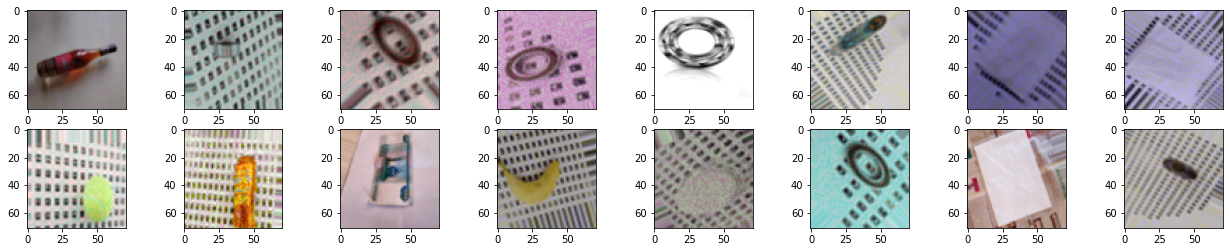

In [ ]:
x_batch, y_batch = next(train_generator)       #(train_generator)
n = 8 # Количество выводимых картинок
fig, axs = plt.subplots(2, n, figsize=(22, 4)) # Создаем полотно из n графиков
for i in range(n): # Проходим по классам
    axs[0,i].imshow(x_batch[i]) # Отображаем фото
for i in range(n): # Проходим по классам
    axs[1,i].imshow(x_batch[i+n]) # Отображаем фото
plt.show() # Показываем изображения  

# Train

In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 20
    if epoch % decay_step == 0 and epoch: lr *= 0.1

    return lr

callbacks = [ LearningRateScheduler(lr_scheduler, verbose=0),
              ModelCheckpoint(filepath='/content/drive/MyDrive/mgen.h5',
              verbose=0, save_best_only=True, save_weights_only=False)     ]

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
    epochs=50, callbacks=callbacks, verbose=1)

Epoch 1/50
234/234 [==============================] - 63s 128ms/step - loss: 1.8961 - accuracy: 0.3524 - val_loss: 1.7460 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 2/50
234/234 [==============================] - 28s 121ms/step - loss: 1.0359 - accuracy: 0.6362 - val_loss: 1.1036 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 3/50
234/234 [==============================] - 29s 123ms/step - loss: 0.7304 - accuracy: 0.7380 - val_loss: 0.7768 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 4/50
234/234 [==============================] - 31s 134ms/step - loss: 0.5986 - accuracy: 0.7917 - val_loss: 0.5723 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 5/50
234/234 [==============================] - 29s 122ms/step - loss: 0.5299 - accuracy: 0.8140 - val_loss: 0.6198 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 6/50
234/234 [==============================] - 29s 123ms/step - loss: 0.4631 - accuracy: 0.8381 - val_loss: 0.5257 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 7/50
234/234 [==============================] 

In [ ]:
import matplotlib.pyplot as plt   # для отрисовки графиков

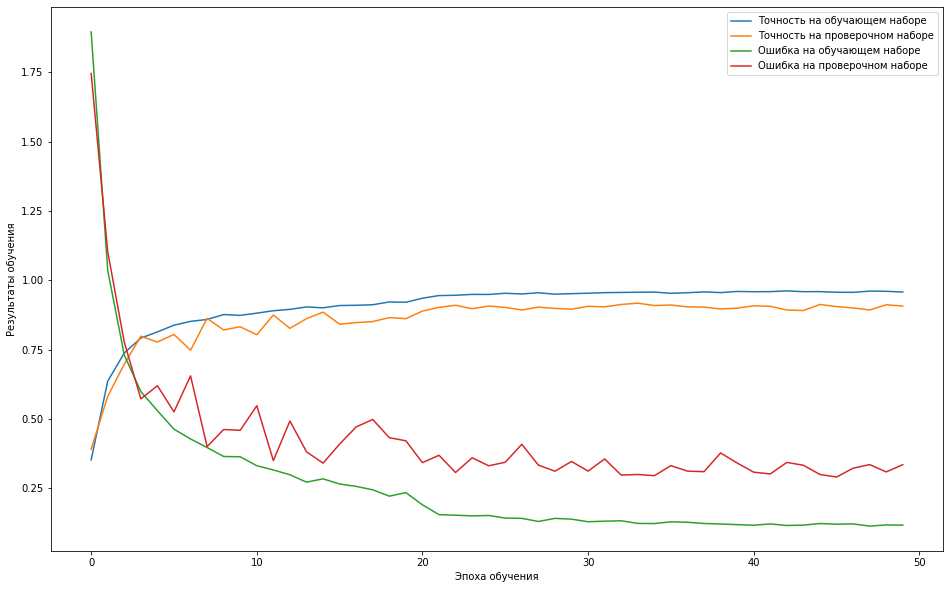

In [ ]:
def gplot(ghist):
  # ghist - history.history
  # График точности обучения
  plt.figure(figsize=(16, 10))
  plt.plot(ghist['accuracy'], label='Точность на обучающем наборе')    
  plt.plot(ghist['val_accuracy'], label='Точность на проверочном наборе')
  plt.plot(ghist['loss'], label='Ошибка на обучающем наборе')    
  plt.plot(ghist['val_loss'], label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Результаты обучения')
  plt.legend()
  plt.show()

gplot(history.history)  

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
    epochs=30, callbacks=callbacks, verbose=1)

Epoch 1/30
234/234 [==============================] - 29s 122ms/step - loss: 0.1107 - accuracy: 0.9635 - val_loss: 0.3230 - val_accuracy: 0.9062 - lr: 1.0000e-05
Epoch 2/30
234/234 [==============================] - 28s 121ms/step - loss: 0.1231 - accuracy: 0.9586 - val_loss: 0.3190 - val_accuracy: 0.9233 - lr: 1.0000e-05
Epoch 3/30
234/234 [==============================] - 28s 121ms/step - loss: 0.1116 - accuracy: 0.9603 - val_loss: 0.3027 - val_accuracy: 0.8958 - lr: 1.0000e-05
Epoch 4/30
234/234 [==============================] - 28s 122ms/step - loss: 0.1163 - accuracy: 0.9587 - val_loss: 0.3023 - val_accuracy: 0.8949 - lr: 1.0000e-05
Epoch 5/30
234/234 [==============================] - 31s 131ms/step - loss: 0.1107 - accuracy: 0.9600 - val_loss: 0.3018 - val_accuracy: 0.9025 - lr: 1.0000e-05
Epoch 6/30
234/234 [==============================] - 29s 122ms/step - loss: 0.1076 - accuracy: 0.9626 - val_loss: 0.3253 - val_accuracy: 0.9119 - lr: 1.0000e-05
Epoch 7/30
234/234 [========

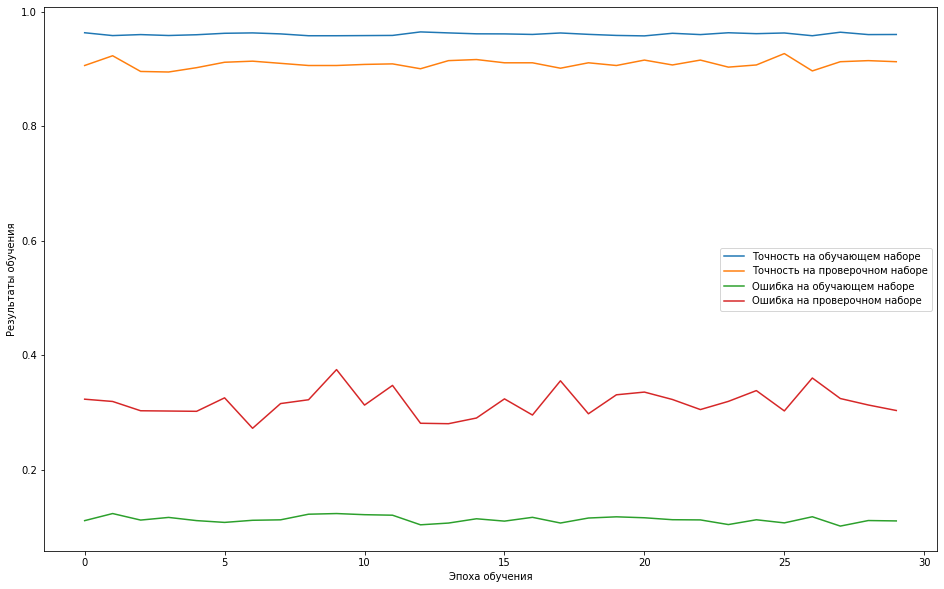

In [ ]:
gplot(history.history)  

Проверяем на наборе из интернета/камеры

In [ ]:
dl = CheckLoader('/content/check/')
className = dl.loadDataVal()
del dl
nClasses = len(className)
xVal = np.array(xVal)
yVal = utils.to_categorical(yVal, nClasses)   
print(xVal.shape, yVal.shape) 
model.load_weights('/content/drive/MyDrive/mgen.h5')
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (100, 71, 71, 3) (100, 10)
0 bag
1/1 [==============================] - 1s 720ms/step - loss: 0.0496 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 35ms/step - loss: 2.2173e-06 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 35ms/step - loss: 0.0141 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 38ms/step - loss: 0.1648 - accuracy: 0.9000
4 can
1/1 [==============================] - 0s 35ms/step - loss: 1.0210 - accuracy: 0.8000
5 env
1/1 [==============================] - 0s 46ms/step - loss: 1.4993e-04 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 38ms/step - loss: 0.8095 - accuracy: 0.6000
7 mon
1/1 [==============================] - 0s 39ms/step - loss: 0.0467 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 38ms/step - loss: 0.2786 - accuracy: 1.0000
9 toy
1/1 [==============================] - 0s 41ms/step - loss: 1.7343 - a

Проверяем на отброшенных данных

In [ ]:
dl = CheckLoader('/content/test/')
className = dl.loadDataVal()
del dl
nClasses = len(className)
xVal = np.array(xVal)
yVal = utils.to_categorical(yVal, nClasses)   
print(xVal.shape, yVal.shape) 
model.load_weights('/content/drive/MyDrive/mgen.h5')
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (67111, 71, 71, 3) (67111, 10)
0 bag
131/131 [==============================] - 2s 16ms/step - loss: 0.0096 - accuracy: 0.9974
1 bal
242/242 [==============================] - 3s 13ms/step - loss: 1.1337e-05 - accuracy: 1.0000
2 ban
62/62 [==============================] - 1s 16ms/step - loss: 0.0054 - accuracy: 0.9980
3 bea
218/218 [==============================] - 3s 12ms/step - loss: 0.0085 - accuracy: 0.9986
4 can
272/272 [==============================] - 3s 12ms/step - loss: 0.1686 - accuracy: 0.9810
5 env
42/42 [==============================] - 1s 16ms/step - loss: 1.4547e-04 - accuracy: 1.0000
6 gbt
65/65 [==============================] - 1s 14ms/step - loss: 0.0293 - accuracy: 0.9902
7 mon
233/233 [==============================] - 3s 11ms/step - loss: 0.0068 - accuracy: 0.9988
8 pbt
234/234 [==============================] - 3s 11ms/step - loss: 0.0850 - accuracy: 0.9716
9 toy
605/605 [============================

Обе диаграммы

In [ ]:
model.load_weights('/content/drive/MyDrive/mgen.h5')

In [ ]:
vAccuracy =[]
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на проверочной выборке
  mx = model.evaluate(xVal[mask], yVal[mask])
  vAccuracy.append(mx[1])

0 bag
1/1 [==============================] - 1s 1s/step - loss: 0.0496 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 234ms/step - loss: 2.2173e-06 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 249ms/step - loss: 0.0141 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 239ms/step - loss: 0.1648 - accuracy: 0.9000
4 can
1/1 [==============================] - 0s 236ms/step - loss: 1.0210 - accuracy: 0.8000
5 env
1/1 [==============================] - 0s 236ms/step - loss: 1.4992e-04 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 250ms/step - loss: 0.8095 - accuracy: 0.6000
7 mon
1/1 [==============================] - 0s 236ms/step - loss: 0.0467 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 241ms/step - loss: 0.2786 - accuracy: 1.0000
9 toy
1/1 [==============================] - 0s 238ms/step - loss: 1.7343 - accuracy: 0.7000


In [ ]:
model.load_weights('/content/drive/MyDrive/mga3.h5')

In [ ]:
cAccuracy =[]
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на проверочной выборке
  mx = model.evaluate(xVal[mask], yVal[mask])
  cAccuracy.append(mx[1])

0 bag
1/1 [==============================] - 0s 246ms/step - loss: 0.1204 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 278ms/step - loss: 0.0669 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 237ms/step - loss: 0.0090 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 244ms/step - loss: 0.0183 - accuracy: 1.0000
4 can
1/1 [==============================] - 0s 243ms/step - loss: 0.4089 - accuracy: 0.9000
5 env
1/1 [==============================] - 0s 246ms/step - loss: 0.0779 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 244ms/step - loss: 0.0371 - accuracy: 1.0000
7 mon
1/1 [==============================] - 0s 234ms/step - loss: 0.0045 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 235ms/step - loss: 0.2092 - accuracy: 0.9000
9 toy
1/1 [==============================] - 0s 237ms/step - loss: 0.6361 - accuracy: 0.8000


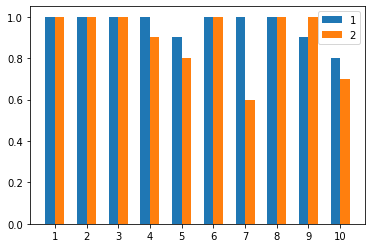

In [ ]:

width = 0.3
xl = [f"{i+1}" for i in range(10)]
x = np.arange(len(xl))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cAccuracy, width, label='1')
rects2 = ax.bar(x + width/2, vAccuracy, width, label='2')
#ax.set_title('Пример групповой диаграммы')
ax.set_xticks(x)
ax.set_xticklabels(xl)
ax.legend()

Дообучение после генератора

In [ ]:
model.load_weights('/content/drive/MyDrive/mgen.h5')
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

0 bag
1/1 [==============================] - 0s 36ms/step - loss: 0.0496 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 34ms/step - loss: 2.2173e-06 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 38ms/step - loss: 0.0141 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 34ms/step - loss: 0.1648 - accuracy: 0.9000
4 can
1/1 [==============================] - 0s 35ms/step - loss: 1.0210 - accuracy: 0.8000
5 env
1/1 [==============================] - 0s 34ms/step - loss: 1.4993e-04 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 39ms/step - loss: 0.8095 - accuracy: 0.6000
7 mon
1/1 [==============================] - 0s 40ms/step - loss: 0.0467 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 38ms/step - loss: 0.2786 - accuracy: 1.0000
9 toy
1/1 [==============================] - 0s 35ms/step - loss: 1.7343 - accuracy: 0.7000


In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 6
    if epoch % decay_step == 0 and epoch: lr *= 0.1

    return lr

callbacks = [ LearningRateScheduler(lr_scheduler, verbose=0),
              ModelCheckpoint(filepath='/content/drive/MyDrive/mgagen.h5',
              verbose=0, save_best_only=True, save_weights_only=False)  ]   

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=40, epochs=10, validation_data=(xVal, yVal),     # дообучение       
                      callbacks=callbacks, verbose=1, shuffle=True)

Epoch 1/7
215/215 [==============================] - 12s 56ms/step - loss: 0.0528 - accuracy: 0.9837 - val_loss: 0.5082 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 2/7
215/215 [==============================] - 12s 56ms/step - loss: 0.0417 - accuracy: 0.9875 - val_loss: 0.5183 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 3/7
215/215 [==============================] - 12s 56ms/step - loss: 0.0408 - accuracy: 0.9887 - val_loss: 0.5069 - val_accuracy: 0.8700 - lr: 1.0000e-04
Epoch 4/7
215/215 [==============================] - 12s 56ms/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.5258 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 5/7
215/215 [==============================] - 13s 58ms/step - loss: 0.0334 - accuracy: 0.9885 - val_loss: 0.4898 - val_accuracy: 0.8700 - lr: 1.0000e-04
Epoch 6/7
215/215 [==============================] - 12s 56ms/step - loss: 0.0292 - accuracy: 0.9916 - val_loss: 0.4994 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 7/7
215/215 [=====================

In [ ]:
model.load_weights('/content/drive/MyDrive/mgagen.h5')
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xVal[mask], yVal[mask])

0 bag
1/1 [==============================] - 0s 43ms/step - loss: 0.0608 - accuracy: 1.0000
1 bal
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000
2 ban
1/1 [==============================] - 0s 34ms/step - loss: 0.0086 - accuracy: 1.0000
3 bea
1/1 [==============================] - 0s 39ms/step - loss: 0.0564 - accuracy: 1.0000
4 can
1/1 [==============================] - 0s 35ms/step - loss: 0.9499 - accuracy: 0.8000
5 env
1/1 [==============================] - 0s 36ms/step - loss: 1.3254e-04 - accuracy: 1.0000
6 gbt
1/1 [==============================] - 0s 42ms/step - loss: 1.1432 - accuracy: 0.7000
7 mon
1/1 [==============================] - 0s 39ms/step - loss: 0.0024 - accuracy: 1.0000
8 pbt
1/1 [==============================] - 0s 44ms/step - loss: 0.5998 - accuracy: 0.8000
9 toy
1/1 [==============================] - 0s 43ms/step - loss: 2.0763 - accuracy: 0.7000
